In [1]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Poisson_Model_T, SafeMatern32_Model, All_Matern_Model, Poisson_Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set()
sns.set_style('white')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['figure.dpi'] = 100


%load_ext autoreload
%autoreload 2

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('../data/gp_weekly_nta_data.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

data.DATE_IND = data.DATE_IND.astype(float) / 100  # try to bring down variance scale
data.x_point = data.x_point.astype(float) / 100  # try to bring down variance scale
data.y_point = data.y_point.astype(float) / 100  # try to bring down variance scale

data.rename(columns={'INJURED':'COUNT'},inplace=True)

data.COUNT = data.COUNT.astype(float)

data = data[data.BoroName == 'Manhattan']

e_s = data[data.DATETIME < '2013-01-01'].e_s.mean()

print(e_s)

7.34046141428


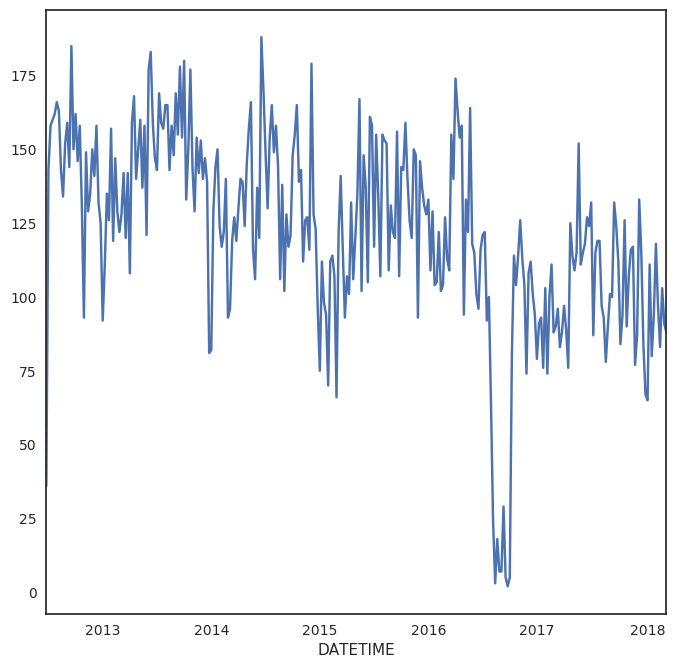

In [3]:
data.groupby('DATETIME')['COUNT'].sum().plot()

In [4]:
search_periods = [[52,26]]

Beginning run [52, 26] : 
Training ends on: 2014-01-05 00:00:00
testing ends on: 2014-07-06 00:00:00
using the safe Matern!
using the safe Matern!
Initial neg. log-likelihood: -77493.5571133
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3689.134122
  Number of iterations: 2002
  Number of functions evaluations: 2186
using the safe Matern!
using the safe Matern!
Using kernel component Sum
using the safe Matern!
using the safe Matern!
added gp pred and error to test
gp_sq_error    7.189987
0              7.249337
dtype: float64


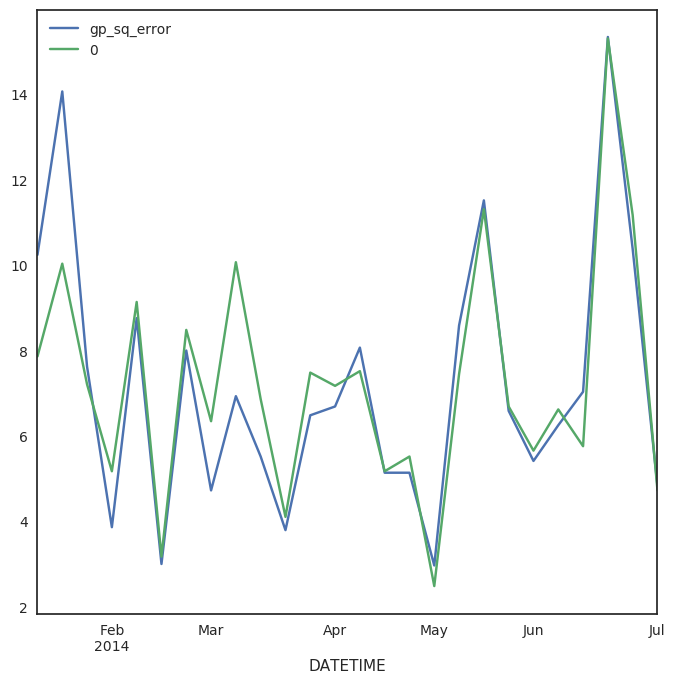

In [91]:
## NOTE: PoissonT: 2rbfs run for 2k+ iters with no priors

for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2013/1/06', training_end_date= s[0], \
                                                           testing_end_date=s[1])


    m =  SafeMatern32_Model(data_dict['X_train'],data_dict['y_train'],use_priors=False, e_s = e_s , period = 1, partial=True)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 2500)
    
    u.pred_GP(m,data_dict)
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    ar = ar 
    summary = pd.concat([gp,ar],axis=1)
    print(summary.mean())


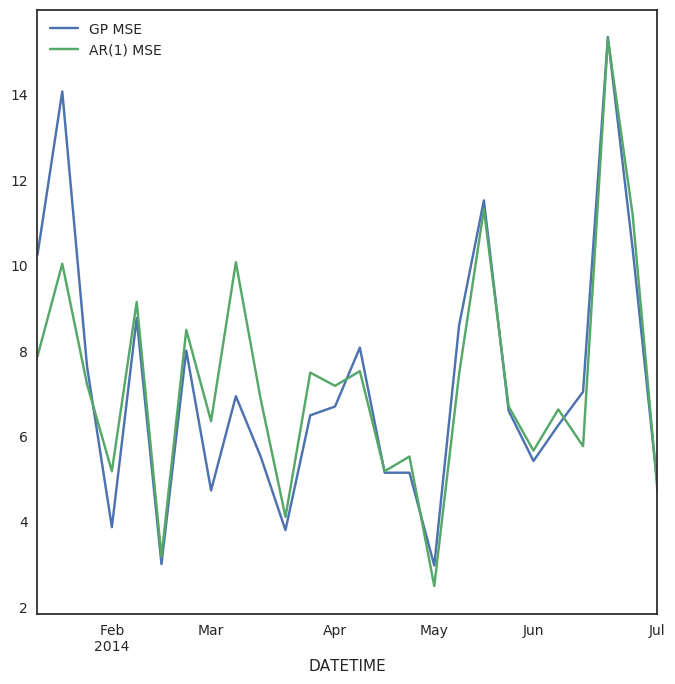

In [150]:
summary.plot()
plt.legend(['GP MSE','AR(1) MSE'])

In [92]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
PartialVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 1537, 1537)",True,"[[[0.139448722826, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
PartialVGP/kern/periodic/lengthscales,Parameter,None,+ve,True,(),True,0.14678318071812538
PartialVGP/kern/periodic/variance,Parameter,None,+ve,True,(),True,0.02375682379801477
PartialVGP/kern/periodic/period,Parameter,None,+ve,True,(),True,0.5348371950909984
PartialVGP/kern/rbf/lengthscales,Parameter,None,+ve,True,(),True,1.0799459692767863
PartialVGP/kern/rbf/variance,Parameter,None,+ve,True,(),True,0.3520323917089429
PartialVGP/kern/safematern32/lengthscales,Parameter,None,+ve,True,(),True,0.0035758334915324537
PartialVGP/kern/safematern32/variance,Parameter,None,+ve,True,(),True,0.26799593058200444
PartialVGP/kern/rbf/lengthscales,Parameter,None,+ve,True,(),True,1.0799459692767863
PartialVGP/kern/rbf/variance,Parameter,None,+ve,True,(),True,0.3520323917089429


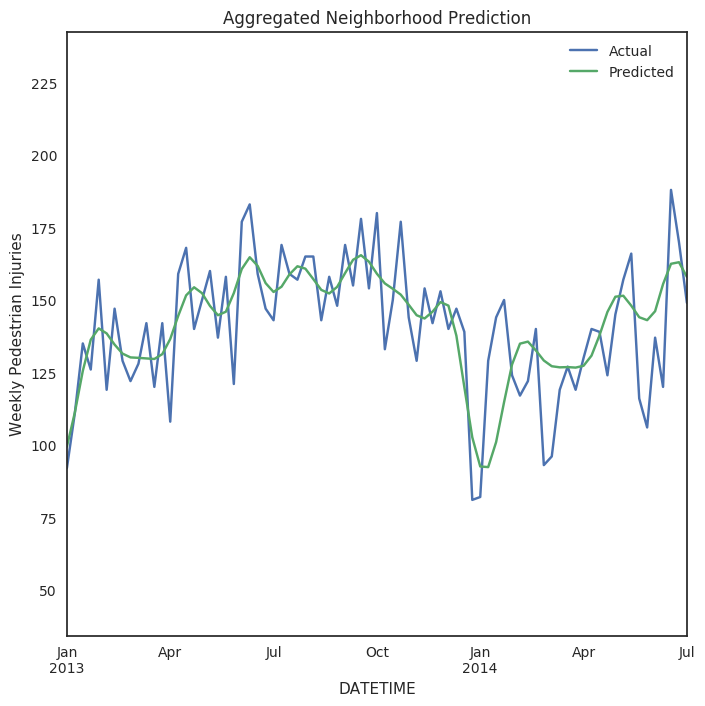

In [157]:
pred_train = m.predict_y(data_dict['X_train'])
pred_test = m.predict_y(data_dict['X_test'])

train = data_dict['train']
train['gp_pred'] = pred_train[0]
train['gp_var'] = pred_train[1]

test = data_dict['test']
test['gp_pred'] = pred_test[0]
test['gp_var'] = pred_test[1]


pred = train.append(test)[['NTAName','DATE_IND','COUNT','gp_pred','gp_var']]

pred['gp_err'] = np.sqrt(pred.gp_var)
pred['err_upper'] = pred.gp_pred + np.sqrt(pred.gp_var) * .95
pred['err_lower'] = pred.gp_pred - np.sqrt(pred.gp_var) * .95
pred['e_err'] = pred.COUNT - e_s

gb = pred.groupby('DATETIME').sum()
p = gb[['COUNT','gp_pred']].plot()
plt.plot(gb.err_lower, linestyle = ':', color = 'black', linewidth = 1)
plt.ylabel('Weekly Pedestrian Injuries')
plt.legend(['Actual','Predicted'])
plt.axvline('2014-01-12', linestyle='--', color = 'black', linewidth = 0.7)
plt.plot(gb.err_upper, linestyle = '-', color = 'black', linewidth = 1)
plt.title('Aggregated Neighborhood Prediction')


In [159]:
X = np.vstack((data_dict['X_train'],(data_dict['X_test']) ))
y = np.vstack((data_dict['y_train'],(data_dict['y_test']) ))


pred['f_pred'] = m.predict_f(X)[0] 
pred['y_pred'] = m.predict_y(X)[0] 
pred['exp_f_pred'] = np.exp(pred['f_pred'])

pred['mu_rbf'],pred['var_rbf']  = m.predict_f_rbf(X)
pred['mu_matern'], _ = m.predict_f_safematern(X)
pred['mu_periodic'], _ = m.predict_f_periodic(X)
pred['mu_product'], _ = m.predict_f_product(X)
pred['mu_combined'] = pred['mu_rbf'] + pred['mu_matern'] + pred['mu_periodic'] + pred['mu_product']




In [142]:
pred.groupby('NTAName')['exp_f_pred'].mean().to_csv('files/MN_nta_f_pred.csv')

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


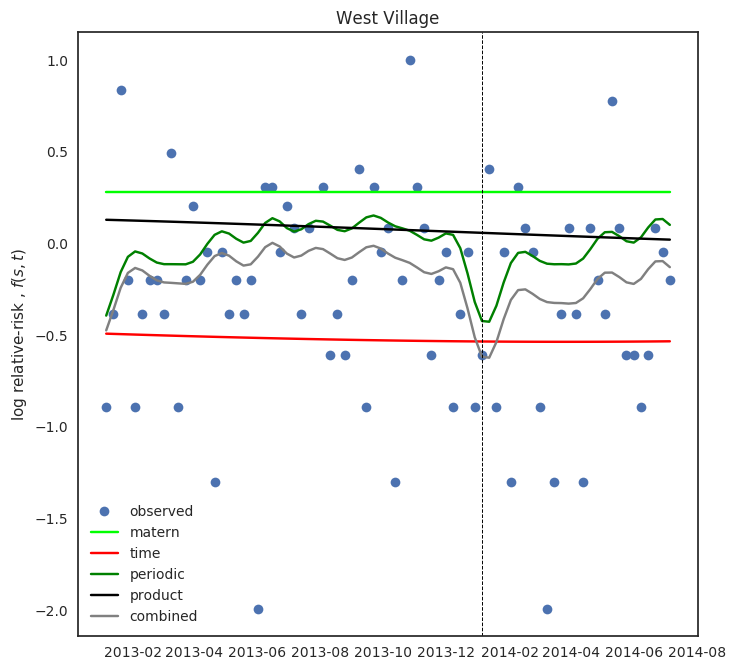

In [161]:
area = 'West Village'

nb = pred[pred.NTAName == area].copy()

idx = nb.index.values
observed = np.log(nb['COUNT'] / e_s)
plt.plot(idx,observed,'o', label = 'observed')
plt.plot(idx, nb['mu_matern'] ,'lime',label = 'matern')
plt.plot(idx, nb['mu_rbf'], 'red' ,label='time')
plt.plot(idx, nb['mu_periodic'], 'green', label='periodic')
plt.plot(idx, nb['mu_product'], 'black',label='product')
plt.plot(idx, nb['f_pred'], 'grey',label='combined')

plt.legend()
plt.ylabel('log relative-risk , $f(s,t)$')
plt.axvline('2014-01-5', linestyle='--', color = 'black', linewidth = 0.7)
plt.title(area)

In [144]:
## Reduction in variance

def calc_var_reduction(c):
    return 1 - (np.square(pred[c]-pred.COUNT).sum() / np.square(pred[['e_err']]).sum())

calc_var_reduction('gp_pred')


e_err    0.645404
dtype: float64

In [145]:
for c in pred.filter(regex='mu_',axis =1):
    pred['pred_{}'.format(c)] = np.exp(pred[c]) * e_s
    print(c)
    print(calc_var_reduction('pred_{}'.format(c)))

mu_rbf
e_err    0.27164
dtype: float64
mu_matern
e_err    0.223193
dtype: float64
mu_periodic
e_err    0.023796
dtype: float64
mu_product
e_err    0.192662
dtype: float64
mu_combined
e_err    0.645816
dtype: float64


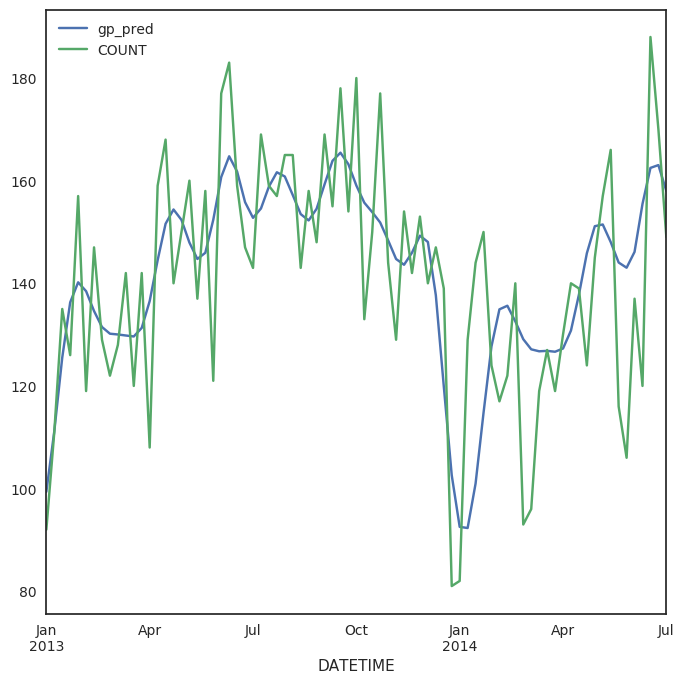

In [146]:
pred_train = m.predict_y(data_dict['X_train'])
train = data_dict['train']
train['gp_pred'] = pred_train[0]
test = data_dict['test']
train.append(test).groupby("DATETIME")['gp_pred','COUNT'].sum().plot()



## This needs:
# train/test normalization has to be split
# prediction has to be done right when looking ahead (sequentially)


In [147]:
df = pred.drop_duplicates( subset=['NTAName','DATE_IND']).copy()

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


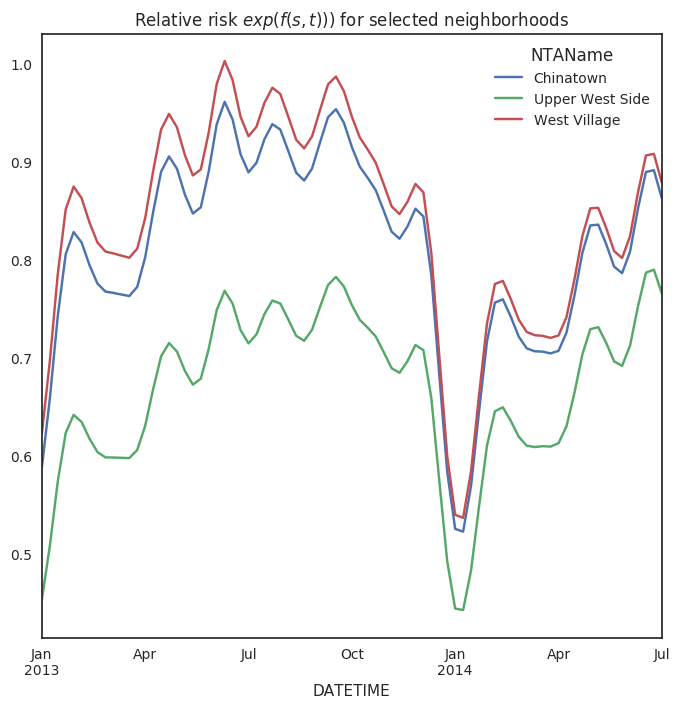

In [148]:
risk_ts = df.groupby(['NTAName','DATETIME'])[['f_pred','exp_f_pred','y_pred','COUNT']].mean()
risk_ts['real_f'] = np.log(risk_ts.COUNT / e_s)
risk_ts.loc[['West Village','Chinatown','Upper West Side','Inwood']]['exp_f_pred'].unstack(-1).T.plot()

plt.title('Relative risk $exp(f(s,t))$) for selected neighborhoods')

## RBF model

In [ ]:
## NOTE: PoissonT: 2rbfs run for 2k+ iters with no priors

for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2013/1/06', training_end_date= s[0], \
                                                           testing_end_date=s[1])


    m =  Poisson_Model_T(data_dict['X_train'],data_dict['y_train'],use_priors=False, e_s = e_s , period = 1, partial=True)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 2500)
    
    u.pred_GP(m,data_dict)
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    ar = ar 
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


In [ ]:
pred_train = m.predict_y(data_dict['X_train'])
train = data_dict['train']
train['gp_pred'] = pred_train[0]
test = data_dict['test']
train.append(test).groupby("DATETIME")['gp_pred','COUNT'].sum().plot()



## This needs:
# train/test normalization has to be split
# prediction has to be done right when looking ahead (sequentially)


In [ ]:
X = np.vstack((data_dict['X_train'],(data_dict['X_test']) ))
y = np.vstack((data_dict['y_train'],(data_dict['y_test']) ))

df = pd.concat([data_dict['train'],data_dict['test']],axis = 0)

df['f_pred'] = m.predict_f(X)[0] 
df['y_pred'] = m.predict_y(X)[0] 
df['exp_f_pred'] = np.exp(df['f_pred'])


In [ ]:
df['mu_rbf1'], _ = m.predict_f_rbf1(X)
df['mu_rbf2'], _ = m.predict_f_rbf2(X)
df['mu_periodic'], _ = m.predict_f_periodic(X)
df['mu_product'], _ = m.predict_f_product(X)
df['mu_combined'] = df['mu_rbf1'] + df['mu_rbf2'] + df['mu_periodic'] + df['mu_product']

In [ ]:
nb = df[df.NTAName == 'West Village'].copy()

idx = nb.index.values
observed = np.log(nb['COUNT'] / e_s)
plt.plot(idx,observed,'o', label = 'observed')
plt.plot(idx, nb['mu_rbf1'] ,'lime',label = 'space')
plt.plot(idx, nb['mu_rbf2'], 'red' ,label='time')
plt.plot(idx, nb['mu_periodic'], 'green', label='periodic')
plt.plot(idx, nb['mu_product'], 'black',label='product')
plt.plot(idx, nb['f_pred'], 'grey',label='combined')

plt.legend()
plt.ylabel('log relative-risk , $f(s,t)$')
plt.axvline('2014-01-5', linestyle='--', color = 'black', linewidth = 0.7)
